# Predicting Registered Voter Participation in Union County NC in the 2016 General Election

## Obtain 2016 Election

In [3]:
## Import Numpy and set random seed for notebook
import numpy as np
np.random.seed(319)

## Import functions made specifically for this project
from capstone_functions import *

## Import remaining necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from tzlocal import get_localzone
import plotly.express as px

## Set options for displaying Pandas DataFrames
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

## Whether or not to display all plotly figures
show_plotly = False

## Import necessary functions/methods/classes for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve

## Import classes necessary for building preprocessing pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

## Import necessary libraries for SNOTE
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

## Import necessary libraries
import xgboost
import shap

## Load JS visualization code to notebook
shap.initjs()

In [4]:
## Import and preview dataset
elec_2016_df = pd.read_csv('Data/UC_gen_2016.gz',
                     dtype={'voting_method': str})
elec_2016_df.head()

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2016,vote_early,vote_by_mail,vote_curbside,Pri_2016,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,birth_state,drivers_lic,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv
0,AA100547,0,61.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,REP,M,1955,2014-03-31,W,UN,28079.0,5514 BEVERLY DR,INDIAN TRAIL,NC,Y,016,016,9.0,20B,20C,35.0,69.0,4.0
1,AA108801,0,53.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,UNA,M,1963,2016-11-04,W,NL,28173.0,4221 OXFORD MILL RD,WAXHAW,MA,Y,020B,020B,9.0,20B,20C,35.0,68.0,6.0
2,AA112504,0,68.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,REP,F,1948,2012-10-26,W,NL,28112.0,4325 WOLF POND RD,MONROE,NY,Y,024,024,9.0,20B,20C,35.0,55.0,2.0
3,AA114763,0,49.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Election Day,DEM,F,1967,2012-08-13,B,UN,28104.0,4002 LAWRENCE DANIEL DR,MATTHEWS,NC,Y,037A,037A,9.0,20B,20C,35.0,69.0,5.0
4,AA118202,0,44.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,DEM,M,1972,2006-04-12,W,UN,28079.0,7006 CONIFER CIR,INDIAN TRAIL,CT,Y,038B,038B,9.0,20B,20C,35.0,69.0,4.0


## Scrub 2016 Election

In [5]:
## Check df metadata
elec_2016_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123222 entries, 0 to 123221
Data columns (total 28 columns):
ncid                  123222 non-null object
no_vote_his           123222 non-null int64
birth_age_adj         123222 non-null float64
voting_method         102225 non-null object
Gen_2016              123222 non-null object
vote_early            123222 non-null float64
vote_by_mail          123222 non-null float64
vote_curbside         123222 non-null float64
Pri_2016              123222 non-null object
party_cd              123222 non-null object
gender_code           123222 non-null object
birth_year            123222 non-null int64
registr_dt            123222 non-null object
race_code             123222 non-null object
ethnic_code           123222 non-null object
zip_code              123219 non-null float64
res_street_address    123222 non-null object
res_city_desc         123219 non-null object
birth_state           94850 non-null object
drivers_lic           123222 non

> Columns with missing values:
* `voting_method`: missing values are all cases where the individual did not cast a vote in this election
* `zip_code`: investigate filling in the 3 missing values based on provided address
* `res_city_desc`: same as for `zip_code`
* `birth_state`: with so many values missing, probably want to make 'missing' its own category for this feature

> Column dtypes:
* `registr_dt`: recast as datetime
* `zip_code`: likely more useful to treat as a categorical variable rather than as numeric
* `drivers_lic`: change from Y or N to 1 or 0

In [6]:
## Change drivers_lic to binary indicator
elec_2016_df['drivers_lic_bin'] = np.where(elec_2016_df['drivers_lic']=='Y', 1, 0)

## Recast zip_code as category
elec_2016_df['zip_code'] = elec_2016_df['zip_code'].astype('category')

## Recast registr_dt as datetime variable
elec_2016_df['registr_dt'] = pd.to_datetime(elec_2016_df['registr_dt'])

## Fill null values in voting_method with 'No Vote'
elec_2016_df['voting_method'].fillna(value='No Vote', inplace=True)

## Fill null values in birth_state with 'Missing'
elec_2016_df['birth_state'].fillna(value='Missing', inplace=True)

## Check records with missing zip_code
elec_2016_df.loc[elec_2016_df['zip_code'].isna()]

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2016,vote_early,vote_by_mail,vote_curbside,Pri_2016,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,birth_state,drivers_lic,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,drivers_lic_bin
59612,EF173508,0,22.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,REP,M,1994,2016-09-26,W,UN,NaN,CONFIDENTIAL,NaN,NC,Y,017A,017A,9.0,20B,20C,35.0,68.0,3.0,1
77543,EF203192,0,55.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,UNA,F,1961,2016-05-25,W,NL,NaN,CONFIDENTIAL,NaN,PA,Y,029C,029C,9.0,20B,20C,35.0,68.0,5.0,1
88945,EF35182,0,58.0,No Vote,No Vote,0.0,0.0,0.0,No Vote,REP,F,1958,1991-03-15,W,NL,NaN,CONFIDENTIAL,NaN,NC,Y,030,030,9.0,20B,20C,35.0,69.0,1.0,1


> These three records missing `zip_code` also correspond to the three records missing `res_city_desc`, most likely because the residential address is confidential for these individuals. These records will be lumped under the 'Other' category for the less frequently appearing cities created to avoid issues with high cardinality and rare labels.

## Explore 2016 Election

### 2016 Categorical Variables

In [7]:
check_unique('voting_method', elec_2016_df)

## Group original vote methods into more general categories in a new variable
 # Map the original categories to new ones
vote_method_map = {'ABSENTEE ONESTOP': 'Early',
                   'IN-PERSON': 'Election Day',
                   'ABSENTEE BY MAIL': 'Mail',
                   'ABSENTEE CURBSIDE': 'Early',
                   'TRANSFER': 'Other',
                   'PROVISIONAL': 'Other',
                   'CURBSIDE': 'Election Day',
                   'No Vote': 'No Vote'}

# Apply the map to create new vote_method_cat column
elec_2016_df['vote_cat'] = elec_2016_df['voting_method'].map(vote_method_map)

check_unique('vote_cat', elec_2016_df)

check_unique('Gen_2016', elec_2016_df)

,count,%
Early,71235,57.81
Election Day,29829,24.21
No Vote,20997,17.04
Other,1161,0.94


> The 'Other' category is made up of only 1,161 individuals that voted with either a provisional or transfer ballot. Need to consider dropping this extremely rare category or somehow adding those records into one of the other categories.

In [8]:
check_unique('Pri_2016', elec_2016_df)

,count,%
No Vote,79340,64.39
Election Day,29742,24.14
Early,13250,10.75
Other,890,0.72


> 'Other' category also extremely rare for `Pri_2016` as well. If this is used as a predictor, consider changing to a binary variable indicating simply whether or not the person voted in the Primary.

In [9]:
check_unique('party_cd', elec_2016_df)

,count,%
REP,53497,43.42
UNA,39124,31.75
DEM,29957,24.31
LIB,580,0.47
CST,44,0.04
GRE,20,0.02


> LIB, CST, and GRE extremely rare within the county. Need to deal with this in some way, but grouping into a single 'Rare' category won't necessarily solve the issue since that would still represent barely more than 0.5% of voters in this election. It could make sense to combine these three parties with UNA (unaffiliated) to simply represent voters that do not align with one of the two major parties.

In [10]:
check_unique('gender_code', elec_2016_df)

,count,%
F,62865,51.02
M,55183,44.78
U,5174,4.20


In [11]:
check_unique('race_code', elec_2016_df)

,count,%
W,94971,77.07
B,14892,12.09
U,7029,5.70
O,3707,3.01
A,1689,1.37
M,624,0.51
I,308,0.25
P,2,0.00


> The most infrequent categories (Other, Asian, Multiple, Native American, Pacific Islander/Native Hawaiian) each represent less than 5% of voters. To deal with these rare labels, it is probably best from a modeling standpoint to group them all under 'Other'.

In [12]:
check_unique('ethnic_code', elec_2016_df)

,count,%
NL,98402,79.86
UN,20701,16.80
HL,4119,3.34


> Voters that chose to identify themselves as Hispanic or Latino represent less than 5% of voters. Check below to see how disclosed racial and ethnic identities intersect.

In [13]:
## Investigate how race intersects with ethnic code
for code in elec_2016_df['ethnic_code'].unique():
    print('*****{}*****'.format(code))
    display(elec_2016_df.loc[elec_2016_df['ethnic_code']==code]['race_code'].value_counts().to_frame())
    print()

*****UN*****


,race_code
W,10782
U,6098
B,2908
A,480
O,214
M,160
I,58
P,1



*****NL*****


,race_code
W,83152
B,11922
O,1427
A,1203
M,274
I,242
U,181
P,1



*****HL*****


,race_code
O,2066
W,1037
U,750
M,190
B,62
I,8
A,6


> Patterns of intersection between race and ethnicity are somewhat unclear. The majority of voters that chose not to disclose their ethnicity were white (10,782 out of 20,701). The majority of voters that identified themselves as Hispanic or Latino when registering listed their race as 'Other'(2,066 out of 4,119), with the next most frequent category being 'White' (1,037 out of 4,119), then 'Undesignated' (750 out of 4,119). As such, I am uncertain how useful this feature will be as a predictor, especially given that the 'HL' category is so rare.

In [14]:
check_unique('zip_code', elec_2016_df)

,count,%
28173.0,33068,26.84
28110.0,26041,21.13
28079.0,20304,16.48
28104.0,18875,15.32
28112.0,14207,11.53
28103.0,5841,4.74
28174.0,4205,3.41
28227.0,298,0.24
28105.0,183,0.15
28133.0,128,0.10


> Seven of the 12 zip codes are rare labels (each representing less than 5% of the voters). It may be best to use grouped cities as a predictor (see immediately below) rather than zip codes, especially since the two will be highly correlated.

In [15]:
check_unique('res_city_desc', elec_2016_df)

,count,%
MONROE,40248,32.66
WAXHAW,33068,26.84
INDIAN TRAIL,20304,16.48
MATTHEWS,19058,15.47
MARSHVILLE,5841,4.74
WINGATE,4205,3.41
CHARLOTTE,298,0.24
PEACHLAND,128,0.10
MIDLAND,67,0.05
NaN,3,0.00


> There are several rare labels, so if `res_city_desc` is to be used as a predictor, cities besides Monroe, Waxhaw, Indian Trail, and Matthews should probably be combined into an 'Other' category.

In [16]:
check_unique('birth_state', elec_2016_df)

,count,%
NC,35549,28.85
Missing,28372,23.03
NY,9812,7.96
OC,6553,5.32
SC,3743,3.04
OH,3401,2.76
PA,3385,2.75
NJ,3311,2.69
FL,2636,2.14
CA,2270,1.84


> The majority of `birth_state` labels are rare categories (less than 5% of voters). Some of the codes do not appear to be U.S. states or territories. These rare labels could be dealt with in a couple ways. They could all be grouped into an 'Other' category, or they could be grouped according to geographic region of the U.S. with an additional category for naturalized U.S. citizens.

In [17]:
check_unique('drivers_lic', elec_2016_df)

,count,%
Y,113301,91.95
N,9921,8.05


### 2016 Group Rare Categories

In [18]:
## Create new column that is a binary variable indicating whether the voter
  ## cast a vote in the 2016 election or not
elec_2016_df['Gen_2016_binary'] = np.where(elec_2016_df['Gen_2016']=='No Vote',
                                0, 1)

## Check distribution
check_unique('Gen_2016_binary', elec_2016_df)

## Create new column that is a binary variable indicating whether the voter
  ## cast a vote in the 2016 election or not
elec_2016_df['Pri_2016_binary'] = np.where(elec_2016_df['Pri_2016']=='No Vote',
                                0, 1)

## Check distribution
check_unique('Pri_2016_binary', elec_2016_df)

## Create new column grouping most infrequent party categories (<5% of voters)
  ## into same group as those who are unaffiliated
elec_2016_df['party_grp'] = np.where(elec_2016_df['party_cd'].isin(['REP', 'DEM']),
                                elec_2016_df['party_cd'].str.title(), 'Other')

## Check distribution
check_unique('party_grp', elec_2016_df)

## Create new column grouping most infrequent race categories (<5% of voters)
elec_2016_df['race_grp'] = np.where(elec_2016_df['race_code'].isin(['W', 'B', 'U']),
                               elec_2016_df['race_code'], 'O')
race_grp_map = {'W': 'White',
                'B': 'Black',
                'U': 'Undesig.',
                'O': 'Other'}
elec_2016_df['race_grp'] = elec_2016_df['race_grp'].map(race_grp_map)

## Check distribution
check_unique('race_grp', elec_2016_df)

## Create new column grouping most infrequent cities (<5% of voters)
elec_2016_df['city_grp'] = np.where(elec_2016_df['res_city_desc'].isin(['MONROE', 
                                                              'WAXHAW',
                                                              'INDIAN TRAIL',
                                                              'MATTHEWS']),
                                elec_2016_df['res_city_desc'].str.title(), 'Other')

## Check distribution
check_unique('city_grp', elec_2016_df)

## Create a function for grouping birth_state into U.S. Census regions, 
  ## also lumping territories and out of country into 'Other'
def get_birth_reg_census_other(state):
    
    if state in ['AS', 'GU', 'MP', 'PR', 'VI', 'OC']:
        return 'Other'
    
    # the rest of the categories are based on U.S. Census Bureau regions
    elif state in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT',
                     'NJ', 'NY', 'PA']:
        return 'Northeast'
    
    elif state in ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 
                     'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR',
                     'LA', 'OK', 'TX']:
        return 'South'
    
    elif state in ['IL', 'IN', 'MI', 'OH', 'WI',
                     'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
        return 'Midwest'
    
    elif state in ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT',
                     'WY', 'AK', 'CA', 'HI', 'OR', 'WA']:
        return 'West'
    
    else:
        return 'Missing'

## Create a new column grouping birth_state into U.S. Census regions,
  ## this time lumping territories and out of country into 'Other'
elec_2016_df['birth_reg_other'] = elec_2016_df['birth_state'].apply(get_birth_reg_census_other)
check_unique('birth_reg_other', elec_2016_df)

,count,%
South,53949,43.78
Missing,28373,23.03
Northeast,19617,15.92
Midwest,10449,8.48
Other,6879,5.58
West,3955,3.21


### 2016 Numeric Variables

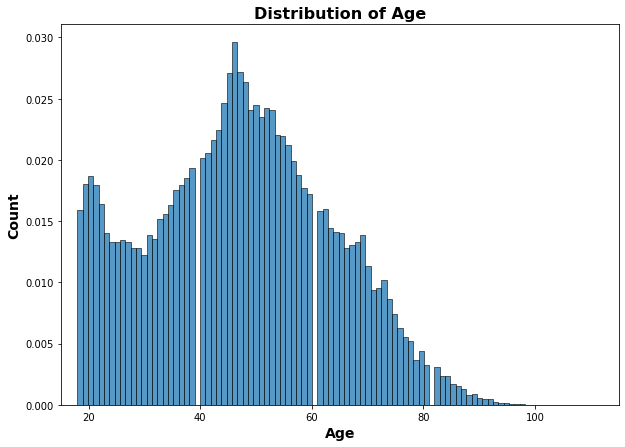

In [19]:
## Plot distribution of current age as of EOY 2016 
plt.figure(figsize=(10,7))
ax = sns.histplot(elec_2016_df['birth_age_adj'], stat='density')
ax.set_title('Distribution of Age', fontsize=16, weight='bold')
ax.set_xlabel('Age', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=14, weight='bold')
ax.set_xlim(15,115);

### 2016 Bin Age into Generation Categories

In [20]:
## Create a function for grouping birth_year into generations
def get_generation(birth_year):
    
    if birth_year <= 1924:
        return 'Greatest'
    
    elif (birth_year > 1923) & (birth_year < 1946):
        return 'Silent'
    
    elif (birth_year > 1945) & (birth_year < 1965):
        return 'Boomer'
    
    elif (birth_year > 1964) & (birth_year < 1981):
        return 'GenX'
    
    elif (birth_year > 1980) & (birth_year < 1997):
        return 'Millennial'
    
    elif birth_year > 1996:
        return 'GenZ'

## Create a a new column grouping birth_year into generations
elec_2016_df['generation'] = elec_2016_df['birth_year'].apply(get_generation)
check_unique('generation', elec_2016_df)

## Create a function for grouping birth_year into generations, 
  ## also lumping Silent in with Greatest
def get_gen_grp(birth_year):
    
    if birth_year < 1946:
        return 'Greatest-Silent'
    
    elif (birth_year > 1945) & (birth_year < 1965):
        return 'Boomer'
    
    elif (birth_year > 1964) & (birth_year < 1981):
        return 'GenX'
    
    elif (birth_year > 1980) & (birth_year < 1997):
        return 'Millennial'
    
    elif birth_year > 1996:
        return 'GenZ'

## Create a new column grouping birth_year into generations, 
  ## also lumping Silent in with Greatest
elec_2016_df['gen_grp'] = elec_2016_df['birth_year'].apply(get_gen_grp)
check_unique('gen_grp', elec_2016_df)

,count,%
GenX,42965,34.87
Boomer,38332,31.11
Millennial,27377,22.22
Greatest-Silent,10554,8.57
GenZ,3994,3.24


### 2016 Load in Full Clean Dataset

In [21]:
## Import and preview dataset
elec_2016_df = pd.read_csv('Data/UC_gen_2016_clean.gz',
                     dtype={'precinct_abbrv': str, 
                            'vtd_abbrv': str
                             })
elec_2016_df.head()

elec_2016_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123222 entries, 0 to 123221
Data columns (total 38 columns):
ncid                  123222 non-null object
no_vote_his           123222 non-null int64
birth_age_adj         123222 non-null float64
voting_method         123222 non-null object
Gen_2016              123222 non-null object
vote_early            123222 non-null float64
vote_by_mail          123222 non-null float64
vote_curbside         123222 non-null float64
Pri_2016              123222 non-null object
party_cd              123222 non-null object
gender_code           123222 non-null object
birth_year            123222 non-null int64
registr_dt            123222 non-null object
race_code             123222 non-null object
ethnic_code           123222 non-null object
zip_code              123219 non-null float64
res_street_address    123222 non-null object
res_city_desc         123219 non-null object
birth_state           123222 non-null object
drivers_lic           123222 no

### 2016 Registered Voter Population Summary

In [22]:
if show_plotly:
    display(basic_px_hist(elec_2016_df, 2016, 'Gen_2016',
              title='Distribution of Voting Methods in 2016 Election'))

if show_plotly:
    display(basic_pie(elec_2016_df, 2016, 'Gen_2016',
              title='Voting Methods in 2016 Election'))

if show_plotly:
    fig = px.histogram(elec_2016_df, x='birth_age_adj', nbins=50,
                       title='Distribution of Registered Voters by Age in 2016 Election',
                       labels={'birth_age_adj': 'Age'},
                       template='seaborn'
                      )
    
    fig.show()

if show_plotly:
    display(basic_px_hist(elec_2016_df, 2016, 'gen_grp',
              title='Distribution of Registered Voters by Generation in 2016 Election'))

if show_plotly:
    display(basic_pie(elec_2016_df, 2016, 'gen_grp',
              title='Registered Voters by Generation in 2016 Election'))

if show_plotly:
    display(basic_px_hist(elec_2016_df, 2016, 'party_grp',
              title='Distribution of Registered Voters by Party Affiliation in 2016 Election'))

if show_plotly:
    display(basic_pie(elec_2016_df, 2016, 'party_grp',
              title='Registered Voters by Party Affiliation in 2016 Election'))

if show_plotly:
    display(basic_px_hist(elec_2016_df, 2016, 'race_grp',
              title='Distribution of Registered Voters by Race in 2016 Election'))

if show_plotly:
    display(basic_pie(elec_2016_df, 2016, 'race_grp',
              title='Registered Voters by Race in 2016 Election'))

if show_plotly:
    display(basic_px_hist(elec_2016_df, 2016, 'gender_code',
              title='Distribution of Registered Voters by Gender in 2016 Election'))

if show_plotly:
    display(basic_pie(elec_2016_df, 2016, 'gender_code',
              title='Registered Voters by Gender in 2016 Election'))

if show_plotly:
    display(basic_px_hist(elec_2016_df, 2016, 'birth_reg_other',
              title='Distribution of Registered Voters by Birth Region in 2016 Election'))

if show_plotly:
    display(basic_pie(elec_2016_df, 2016, 'birth_reg_other',
              title='Registered Voters by Birth Region in 2016 Election'))

if show_plotly:
    display(basic_px_hist(elec_2016_df, 2016, 'drivers_lic',
              title='Distribution of Registered Voters by Drivers License Possession in 2016 Election'))

if show_plotly:
    display(basic_pie(elec_2016_df, 2016, 'drivers_lic',
              title='Possession of Drivers License by Registered Voters in 2016 Election'))

if show_plotly:
    display(basic_px_hist(elec_2016_df, 2016, 'city_grp',
              title='Distribution of Registered Voters by City in 2016 Election'))

if show_plotly:
    display(basic_pie(elec_2016_df, 2016, 'city_grp',
              title='Registered Voters by City in 2016 Election'))

### 2016 Relationship to Voting Method

#### 2016 By Age

In [23]:
if show_plotly:
    display(grp_px_hist(elec_2016_df, 2016, 'birth_age_adj', 'Gen_2016', 
            title='Distribution of Voter Age by Voting Method in 2016 Election'))

if show_plotly:
    display(grp_px_hist(elec_2016_df, 2016, 'gen_grp', 'Gen_2016', 
            title='Voting Method by Generation'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'gen_grp', 'Early',
              title='Early Voters by Generation'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'gen_grp', 'Election Day',
              title='Election Day Voters by Generation'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'gen_grp', 'No Vote',
              title='Non-Voters by Generation'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'gen_grp', 'Other',
              title='Provisional/ Transfer Voters by Generation'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'gen_grp', 'Gen_2016', 'GenZ',
              title='Votes by Gen Z'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'gen_grp', 'Gen_2016', 'Millennial',
              title='Votes by Millennials'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'gen_grp', 'Gen_2016', 'GenX',
              title='Votes by Generation X'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'gen_grp', 'Gen_2016', 'Boomer',
              title='Votes by Baby Boomers'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'gen_grp', 'Gen_2016', 'Greatest-Silent',
              title='Votes by Greatest and Silent Generation'))

#### 2016 By Party

In [24]:
if show_plotly:
    display(grp_px_hist(elec_2016_df, 2016, 'Gen_2016', 'party_grp', 
            title='Voting Method by Party'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'party_grp', 'Early',
              title='Early Voters by Party'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'party_grp', 'Election Day',
              title='Election Day Voters by Party'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'party_grp', 'No Vote',
              title='Non-Voters by Party'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'party_grp', 'Other',
              title='Provisional/ Transfer Voters by Party'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'party_grp', 'Gen_2016', 'Dem',
              title='Votes by Democratic Party'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'party_grp', 'Gen_2016', 'Rep',
              title='Votes by Republican Party'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'party_grp', 'Gen_2016', 'Other',
              title='Votes by Other Voters'))

#### 2016 By Race

In [25]:
if show_plotly:
    display(grp_px_hist(elec_2016_df, 2016, 'Gen_2016', 'race_grp',
            title='Voting Method by Race'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'race_grp', 'Early',
              title='Early Voters by Race'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'race_grp', 'Election Day',
              title='Election Day Voters by Race'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'race_grp', 'No Vote',
              title='Non-Voters by Race'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'race_grp', 'Other',
              title='Provisional/ Transfer Voters by Race'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'race_grp', 'Gen_2016', 'White',
              title='Votes by White Voters'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'race_grp', 'Gen_2016', 'Black',
              title='Votes by Black Voters'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'race_grp', 'Gen_2016', 'Undesig.',
              title='Votes by Voters of Undesignated Race'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'race_grp', 'Gen_2016', 'Other',
              title='Votes by Voters of Other Racial Backgrounds'))

#### 2016 By Gender

In [26]:
if show_plotly:
    display(grp_px_hist(elec_2016_df, 2016, 'Gen_2016', 'gender_code', 
            title='Voting Method by Gender'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'gender_code', 'Early',
              title='Early Voters by Gender'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'gender_code', 'Election Day',
              title='Election Day Voters by Gender'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'gender_code', 'No Vote',
              title='Non-Voters by Gender'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'gender_code', 'Other',
              title='Provisional/ Transfer Voters by Gender'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'gender_code', 'Gen_2016', 'F',
              title='Votes by Women'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'gender_code', 'Gen_2016', 'M',
              title='Votes by Men'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'gender_code', 'Gen_2016', 'U',
              title='Votes by Voters of Undesignated Gender'))

#### 2016 By Birth Region

In [27]:
if show_plotly:
    display(grp_px_hist(elec_2016_df, 2016, 'Gen_2016', 'birth_reg_other', 
            title='Voting Method by Birth Region'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'birth_reg_other', 'Early',
              title='Early Voters by Birth Region'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'birth_reg_other', 'Election Day',
              title='Election Day Voters by Birth Region'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'birth_reg_other', 'No Vote',
              title='Non-Voters by Birth Region'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'birth_reg_other', 'Other',
              title='Provisional/ Transfer Voters by Birth Region'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'birth_reg_other', 'Gen_2016', 'South',
              title='Votes by Voters from the South'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'birth_reg_other', 'Gen_2016', 'Missing',
              title='Votes by Voters with Missing Birth Region'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'birth_reg_other', 'Gen_2016', 'Northeast',
              title='Votes by Voters from the Northeast'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'birth_reg_other', 'Gen_2016', 'Midwest',
              title='Votes by Voters from the Midwest'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'birth_reg_other', 'Gen_2016', 'Other',
              title='Votes by Voters Born in U.S. Territories or Outside the U.S.'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'birth_reg_other', 'Gen_2016', 'West',
              title='Votes by Voters from the West'))

#### 2016 By Possessing a Drivers License

In [28]:
if show_plotly:
    display(grp_px_hist(elec_2016_df, 2016, 'Gen_2016', 'drivers_lic', 
            title='Voting Method by Voters with and without Drivers Licenses'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'drivers_lic', 'Early',
              title='Early Voters by Possession of Drivers License'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'drivers_lic', 'Election Day',
              title='Election Day Voters by Possession of Drivers License'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'drivers_lic', 'No Vote',
              title='Non-Voters by Possession of Drivers License'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'drivers_lic', 'Other',
              title='Provisional/ Transfer Voters by Possession of Drivers License'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'drivers_lic', 'Gen_2016', 'Y',
              title='Votes by People with a Drivers License'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'drivers_lic', 'Gen_2016', 'N',
              title='Votes by People with No Drivers License'))

#### 2016 By City

In [29]:
if show_plotly:
    display(grp_px_hist(elec_2016_df, 2016, 'Gen_2016', 'city_grp', 
            title='Voting Method by City of Residence'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'city_grp', 'Early',
              title='Early Voters by City of Residence'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'city_grp', 'Election Day',
              title='Election Day Voters by City of Residence'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'city_grp', 'No Vote',
              title='Non-Voters by City of Residence'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'Gen_2016', 'city_grp', 'Other',
              title='Provisional/ Transfer Voters by City of Residence'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'city_grp', 'Gen_2016', 'Monroe',
              title='Votes by Residents of Monroe'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'city_grp', 'Gen_2016', 'Waxhaw',
              title='Votes by Residents of Waxhaw'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'city_grp', 'Gen_2016', 'Indian Trail',
              title='Votes by Residents of Indian Trail'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'city_grp', 'Gen_2016', 'Matthews',
              title='Votes by Residents of Matthews'))

if show_plotly:
    display(grp_pie(elec_2016_df, 2016, 'city_grp', 'Gen_2016', 'Other',
              title='Votes from Other Cities in Union County'))

## Model 2016 Election

In [30]:
## Import and preview dataset
elec_2016_df = pd.read_csv('Data/UC_gen_2016_clean.gz',
                     dtype={'precinct_abbrv': str, 
                            'vtd_abbrv': str
                             })
elec_2016_df.head()

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2016,vote_early,vote_by_mail,vote_curbside,Pri_2016,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,birth_state,drivers_lic,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,drivers_lic_bin,vote_cat,Gen_2016_binary,Pri_2016_binary,party_grp,race_grp,city_grp,birth_reg_other,generation,gen_grp
0,AA100547,0,61.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,REP,M,1955,2014-03-31,W,UN,28079.0,5514 BEVERLY DR,INDIAN TRAIL,NC,Y,016,016,9.0,20B,20C,35.0,69.0,4.0,1,Early,1,0,Rep,White,Indian Trail,South,Boomer,Boomer
1,AA108801,0,53.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,UNA,M,1963,2016-11-04,W,NL,28173.0,4221 OXFORD MILL RD,WAXHAW,MA,Y,020B,020B,9.0,20B,20C,35.0,68.0,6.0,1,Early,1,0,Other,White,Waxhaw,Northeast,Boomer,Boomer
2,AA112504,0,68.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,REP,F,1948,2012-10-26,W,NL,28112.0,4325 WOLF POND RD,MONROE,NY,Y,024,024,9.0,20B,20C,35.0,55.0,2.0,1,Early,1,0,Rep,White,Monroe,Northeast,Boomer,Boomer
3,AA114763,0,49.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Election Day,DEM,F,1967,2012-08-13,B,UN,28104.0,4002 LAWRENCE DANIEL DR,MATTHEWS,NC,Y,037A,037A,9.0,20B,20C,35.0,69.0,5.0,1,Early,1,1,Dem,Black,Matthews,South,GenX,GenX
4,AA118202,0,44.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,DEM,M,1972,2006-04-12,W,UN,28079.0,7006 CONIFER CIR,INDIAN TRAIL,CT,Y,038B,038B,9.0,20B,20C,35.0,69.0,4.0,1,Early,1,0,Dem,White,Indian Trail,Northeast,GenX,GenX


### 2016 Binary Target - Vote vs. No Vote

#### 2016 Prepare DataFrame for Modeling - Train Test Split and Preprocessing

In [31]:
## Create new DataFrame from the full cleaned df that only consists of 
  ## the target ('Gen_2016') and desired predictors
model_2016_df = elec_2016_df.copy()
model_2016_df = model_2016_df[['Gen_2016', 'Gen_2016_binary', 'gen_grp', 'party_grp',
                     'race_grp', 'gender_code', 'birth_reg_other',
                     'drivers_lic', 'city_grp']]

# Drop the 'Other' voting method so train-test-splits constant across
## binary and multiclass target models
  ## 'Other' represents provisional and transfer ballots. This type of
    ## vote is not so much generated by a voter's choice as it is by the 
    ## legal process of how votes may be cast.
model_2016_df = model_2016_df.drop(model_2016_df.loc[model_2016_df['Gen_2016']=='Other'].index)

## Inspect the resulting df
display(model_2016_df.head())
len(model_2016_df)

## Check class imbalance
check_unique('Gen_2016_binary', model_2016_df)

## Define target variable
bin_2016_target = 'Gen_2016_binary'

## Separate features (X) and target (y) for train-test-split
X_2016 = model_2016_df.drop(columns=[bin_2016_target, 'Gen_2016'], axis=1).copy()
y_bin_2016 = model_2016_df[bin_2016_target].copy()

## Define random seed to use for train-test-split and 
 ## classifiers for reproducibility
random_seed = 319

## Split the data into training and test sets prior to preprocessing
X_2016_train, X_2016_test, y_bin_2016_train, y_bin_2016_test = train_test_split(X_2016, y_bin_2016,
                                                            test_size=0.25,
                                                            random_state=random_seed)

## Make a list of all columns that are currently object dtype
cat_cols = list(X_2016_train.select_dtypes('O').columns)

## Create a pipeline for one hot encoding categorical columns
cat_transformer = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown='error', 
                          sparse=False,
                          drop='if_binary'))])

## Define pipeline for preprocessing X
preprocessing = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_cols)
])

## Preprocess training and test predictors (X)
X_2016_train_tf = preprocessing.fit_transform(X_2016_train)
X_2016_test_tf = preprocessing.transform(X_2016_test)

## Get the feature names in the order they appear in preprocessed data
feature_names_2016 = preprocessing.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_cols)
feature_names_2016

,Gen_2016,Gen_2016_binary,gen_grp,party_grp,race_grp,gender_code,birth_reg_other,drivers_lic,city_grp
0,Early,1,Boomer,Rep,White,M,South,Y,Indian Trail
1,Early,1,Boomer,Other,White,M,Northeast,Y,Waxhaw
2,Early,1,Boomer,Rep,White,F,Northeast,Y,Monroe
3,Early,1,GenX,Dem,Black,F,South,Y,Matthews
4,Early,1,GenX,Dem,White,M,Northeast,Y,Indian Trail


array(['gen_grp_Boomer', 'gen_grp_GenX', 'gen_grp_GenZ',
       'gen_grp_Greatest-Silent', 'gen_grp_Millennial', 'party_grp_Dem',
       'party_grp_Other', 'party_grp_Rep', 'race_grp_Black',
       'race_grp_Other', 'race_grp_Undesig.', 'race_grp_White',
       'gender_code_F', 'gender_code_M', 'gender_code_U',
       'birth_reg_other_Midwest', 'birth_reg_other_Missing',
       'birth_reg_other_Northeast', 'birth_reg_other_Other',
       'birth_reg_other_South', 'birth_reg_other_West', 'drivers_lic_Y',
       'city_grp_Indian Trail', 'city_grp_Matthews', 'city_grp_Monroe',
       'city_grp_Other', 'city_grp_Waxhaw'], dtype=object)

#### 2016 Best Model - XGBoost Classifier

##### 2016 Baseline XGBoost

-------------------------------------------------------------------
Classification Report: Baseline Binary XGBoost with Default Params
-------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vote       0.61      0.07      0.13      5278
        Vote       0.84      0.99      0.91     25238

    accuracy                           0.83     30516
   macro avg       0.72      0.53      0.52     30516
weighted avg       0.80      0.83      0.77     30516

-------------------------------------------------------------------
-------------------------------------------------------------------




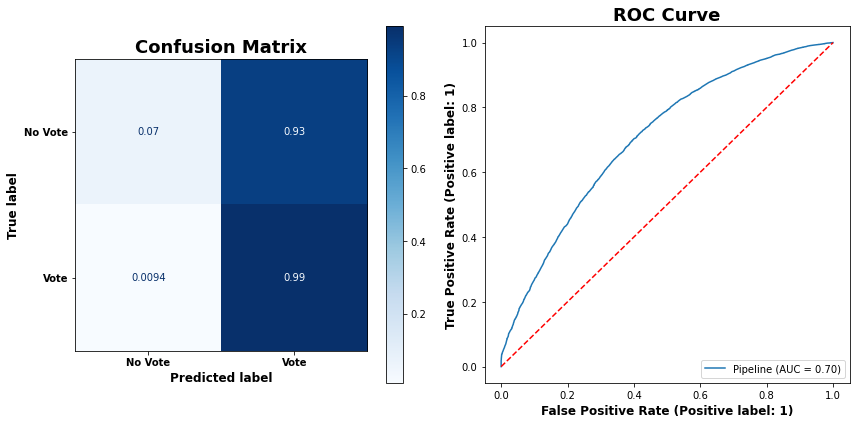

In [32]:
## Use preprocessor as the first step in modeling Pipeline 
xgb_bin_2016 = Pipeline(steps=[('preprocessing', preprocessing),
                          ('xgb', XGBClassifier(random_state=random_seed,
                                                objective='binary:logistic'))])

xgb_bin_2016.fit(X_2016_train, y_bin_2016_train)

eval_bin_clf(xgb_bin_2016, X_2016_test, y_bin_2016_test,
             model_descr='Baseline Binary XGBoost with Default Params');

##### 2016 Tuning XGBoost Hyperparameters

------------------------------------------------------------
***** Grid Search Started at 01/12/21 - 15:53:59 PM
------------------------------------------------------------


***** Training Completed at 01/12/21 - 15:54:25 PM

***** Total Training Time: 0:00:25.276665


Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__eta': 0.1, 'xgb__max_delta_step': 1, 'xgb__max_depth': 4, 'xgb__scale_pos_weight': 0.2, 'xgb__subsample': 0.75}


-------------------------------------------------------------------
Classification Report: Best Binary XGB Tuned for Balanced Accuracy
-------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vote       0.30      0.59      0.40      5278
        Vote       0.89      0.71      0.79     25238

    accuracy                           0.69     30516
   macro avg       0.60      0.65      0.59     30516
weighted avg       0.79      0.69      0.72     30516

------------------------------

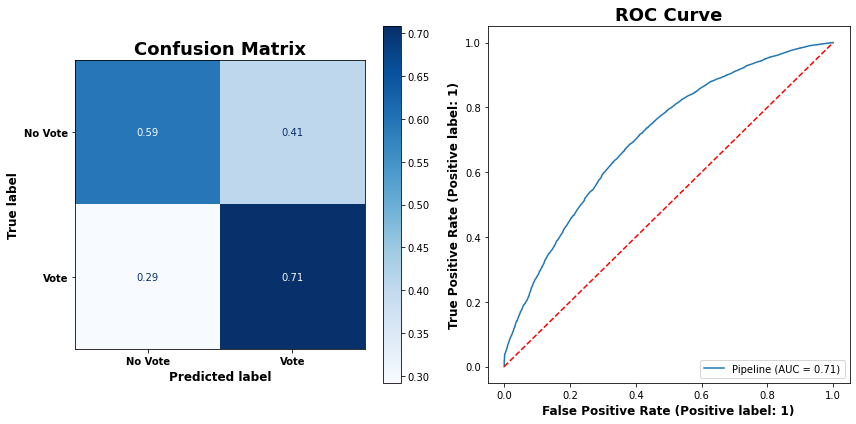

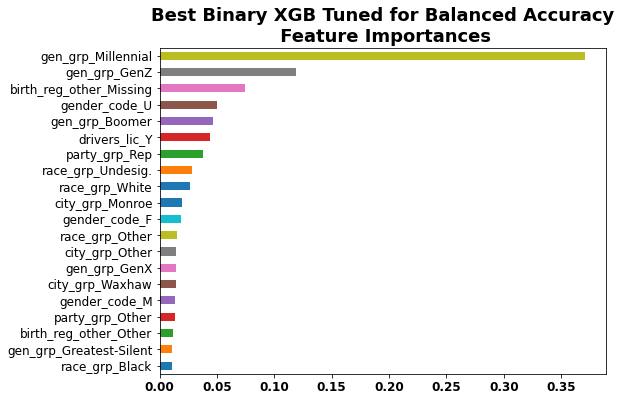

In [33]:
## Define a grid of different hyperparameter values to be tested
params = {
    'xgb__eta':[0.1],
    'xgb__max_depth':[4],
    'xgb__subsample': [0.75],
    'xgb__colsample_bytree': [0.7],
    'xgb__scale_pos_weight': [0.20],
    'xgb__max_delta_step': [1]
}

## run the grid search to test parameters and find the best estimator 
xgb_bin_2016_bacc_grid = fit_grid_clf(xgb_bin_2016, params,
                                 X_2016_train, y_bin_2016_train,
                                 X_2016_test, y_bin_2016_test,
                                 model_descr='Best Binary XGB Tuned for Balanced Accuracy',
                                 score='balanced_accuracy',
                                 bin_target=True)

plot_feat_importance(xgb_bin_2016_bacc_grid.best_estimator_, 'xgb', feature_names_2016,
                      model_title='Best Binary XGB Tuned for Balanced Accuracy\n');

### 2016 Multiclass Target - Early, Election Day, No Vote

#### 2016 Prepare DataFrame for Modeling - Train Test Split and Preprocessing

In [34]:
## Inspect the resulting df
display(model_2016_df.head())
len(model_2016_df)

## Check that only the 3 target classes that represent a voter's choice remain
check_unique('Gen_2016', model_2016_df)

## Define target variable
multi_2016_target = 'Gen_2016'

## Separate features (X) and target (y) for train-test-split
# X = model_2016_df.drop(columns=[bin_2016_target, multi_2016_target], axis=1).copy()
## X was already defined for previous models,
  ## only need to adjust for new target
y_multi_2016 = model_2016_df[multi_2016_target].copy()

## Define random seed to use for train-test-split and 
 ## classifiers for reproducibility
random_seed = 319

## Split the data into training and test sets prior to preprocessing
  ## Random seed same as for binary modeling, so produces same X splits
X_2016_train, X_2016_test, y_multi_2016_train, y_multi_2016_test = train_test_split(X_2016, y_multi_2016,
                                                                test_size=0.25,
                                                    random_state=random_seed)

## Preprocess training and test target (y)
le_2016 = LabelEncoder()
y_multi_2016_train = pd.Series(le_2016.fit_transform(y_multi_2016_train))
y_multi_2016_test = pd.Series(le_2016.transform(y_multi_2016_test))

## Check order of classes
le_2016.classes_

,Gen_2016,Gen_2016_binary,gen_grp,party_grp,race_grp,gender_code,birth_reg_other,drivers_lic,city_grp
0,Early,1,Boomer,Rep,White,M,South,Y,Indian Trail
1,Early,1,Boomer,Other,White,M,Northeast,Y,Waxhaw
2,Early,1,Boomer,Rep,White,F,Northeast,Y,Monroe
3,Early,1,GenX,Dem,Black,F,South,Y,Matthews
4,Early,1,GenX,Dem,White,M,Northeast,Y,Indian Trail


array(['Early', 'Election Day', 'No Vote'], dtype=object)

#### 2016 Best Model - XGBoost with SMOTE

##### 2016 Baseline XGBoost with SMOTE

--------------------------------------------------------------------
Classification Report: Multiclass SMOTE XGBoost with Default Params
--------------------------------------------------------------------
              precision    recall  f1-score   support

       Early       0.68      0.52      0.59     17799
Election Day       0.31      0.39      0.34      7439
     No Vote       0.34      0.49      0.40      5278

    accuracy                           0.48     30516
   macro avg       0.44      0.46      0.44     30516
weighted avg       0.53      0.48      0.50     30516

--------------------------------------------------------------------
--------------------------------------------------------------------




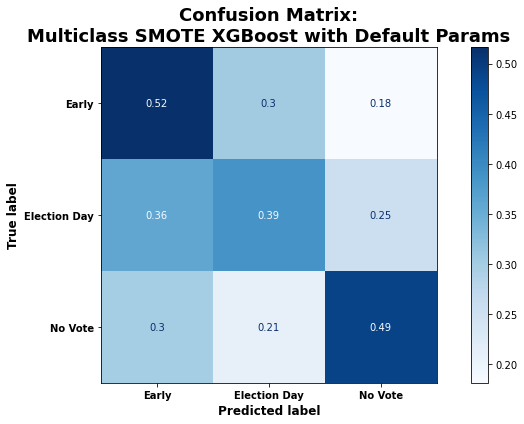

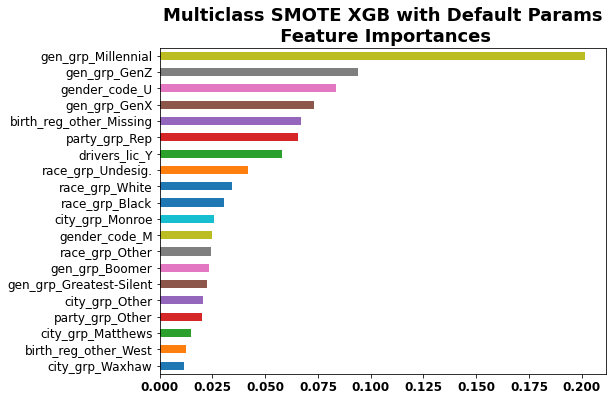

In [35]:
## Use preprocessor as the first step in modeling Pipeline,
  ## followed by SMOTE for oversampling
xgb_multi_2016_smote = imbPipeline(steps=[
    ('preprocessing', preprocessing),
    ('sampler', SMOTE(random_state=random_seed, n_jobs=-1)),
    ('xgb', XGBClassifier(random_state=random_seed))])

xgb_multi_2016_smote.fit(X_2016_train, y_multi_2016_train)

eval_classifier(xgb_multi_2016_smote, X_2016_test, y_multi_2016_test,
                model_descr='Multiclass SMOTE XGBoost with Default Params');

plot_feat_importance(xgb_multi_2016_smote, 'xgb', feature_names_2016,
                     model_title='Multiclass SMOTE XGB with Default Params\n');

##### 2016 Tuning XGBoost with SMOTE Hyperparameters

------------------------------------------------------------
***** Grid Search Started at 01/12/21 - 15:55:46 PM
------------------------------------------------------------


***** Training Completed at 01/12/21 - 15:58:22 PM

***** Total Training Time: 0:02:35.310025


Best Parameters:
{'sampler__k_neighbors': 3, 'xgb__colsample_bytree': 0.65, 'xgb__eta': 0.1, 'xgb__max_delta_step': 1, 'xgb__max_depth': 4, 'xgb__subsample': 0.85}


-----------------------------------------------------------------------------
Classification Report: Best Multiclass SMOTE XGB Tuned for Balanced Accuracy
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

       Early       0.69      0.51      0.58     17799
Election Day       0.31      0.38      0.34      7439
     No Vote       0.33      0.51      0.40      5278

    accuracy                           0.48     30516
   macro avg       0.44      0.47      0.44     30516
wei

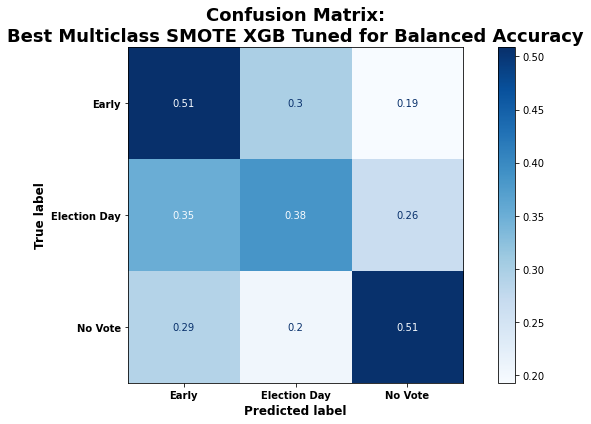

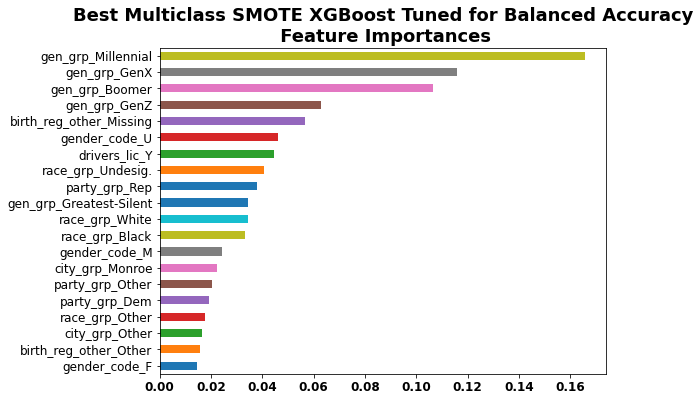

In [36]:
## Define a grid of different hyperparameter values to be tested
params = {
    'sampler__k_neighbors':[3],
    'xgb__eta':[0.1],
    'xgb__max_depth':[4],
    'xgb__subsample': [0.85],
    'xgb__colsample_bytree': [0.65],
    'xgb__max_delta_step': [1]
}

## run the grid search to test parameters and find the best estimator 
xgb_multi_2016_smote_bacc_grid = fit_grid_clf(xgb_multi_2016_smote, params,
                             X_2016_train, y_multi_2016_train,
                             X_2016_test, y_multi_2016_test,
                             model_descr='Best Multiclass SMOTE XGB Tuned for Balanced Accuracy',
                             score='balanced_accuracy')

plot_feat_importance(xgb_multi_2016_smote_bacc_grid.best_estimator_, 'xgb', feature_names_2016,
                     model_title='Best Multiclass SMOTE XGBoost Tuned for Balanced Accuracy\n');

## Interpret 2016 Election

In [37]:
## Convert transformed (preprocessed) X train set into pandas DataFrame
X_2016_train_df = pd.DataFrame(X_2016_train_tf, columns=feature_names_2016)
X_2016_train_df.head()

,gen_grp_Boomer,gen_grp_GenX,gen_grp_GenZ,gen_grp_Greatest-Silent,gen_grp_Millennial,party_grp_Dem,party_grp_Other,party_grp_Rep,race_grp_Black,race_grp_Other,race_grp_Undesig.,race_grp_White,gender_code_F,gender_code_M,gender_code_U,birth_reg_other_Midwest,birth_reg_other_Missing,birth_reg_other_Northeast,birth_reg_other_Other,birth_reg_other_South,birth_reg_other_West,drivers_lic_Y,city_grp_Indian Trail,city_grp_Matthews,city_grp_Monroe,city_grp_Other,city_grp_Waxhaw
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### 2016 Binary Target Model

In [38]:
## Store the booster (trained model)
bin_2016_model = xgb_bin_2016_bacc_grid.best_estimator_.named_steps['xgb'].get_booster()

## Explain the model's predictions using SHAP
bin_2016_explainer = shap.TreeExplainer(bin_2016_model)
bin_2016_shap_values = bin_2016_explainer.shap_values(X_2016_train_df)

In [39]:
## Print model prediction for third row of training set
print(xgb_bin_2016_bacc_grid.best_estimator_.named_steps['xgb'].predict(X_2016_train_df.iloc[2,:]))
# (0, no vote)

## Print ground truth label third row of training set
print('Actual: ', 
      y_bin_2016_train.iloc[2])
# (0, truly did not vote)

## Visualize the third prediction's explanation
shap.force_plot(bin_2016_explainer.expected_value,
                bin_2016_shap_values[2,:],
                X_2016_train_df.iloc[2,:])

[0]
Actual:  0


The plot above visualizes how the model is making its prediction for the third individual in the training set. 
> The third individual did not vote and the model predicted this correctly. The model was pushed towards the prediction of "No Vote" (0) by the fact that the individual belongs to Gen Z. The fact that the individual is not a Republican, is not missing birthplace information, and resides in Monroe also pushed the model towards the correct prediction of "No Vote" for this individual.

In [40]:
## Print model prediction for seventh row of training set
print('Prediction: ', 
      xgb_bin_2016_bacc_grid.best_estimator_.named_steps['xgb'].predict(X_2016_train_df.iloc[6,:]))
# (1, voted)

## Print ground truth label seventh row of training set
print('Actual: ', 
      y_bin_2016_train.iloc[6])
# (1, truly did vote)

## Visualize the seventh prediction's explanation
shap.force_plot(bin_2016_explainer.expected_value,
                bin_2016_shap_values[6,:],
                X_2016_train_df.iloc[6,:])

Prediction:  [1]
Actual:  1


The plot immediately above visualizes how the model is making its prediction for the seventh individual in the training set. 
> The seventh individual voted and the model predicted this correctly. The model was pushed towards the prediction of "vote" (1) by the fact that their birth region information was missing, they belong to the Baby Boomer generation (and thus are not a millenial or Gen Z), and they have a drivers license. The fact the this person is not a Republican and resides in Monroe pushed the model in the incorrect direction towards "No Vote" (0), but not enough to overwhelm the factors more predictive of "Vote" (1).

The plot below shows the impact each feature had on the model's output (predictions) quantified in terms of SHAP values. The top 3 features (after which there is a drop in impact) are `gen_grp_Millennial`, `birth_reg_other_Missing`, and `party_grp_Rep`, respectively.

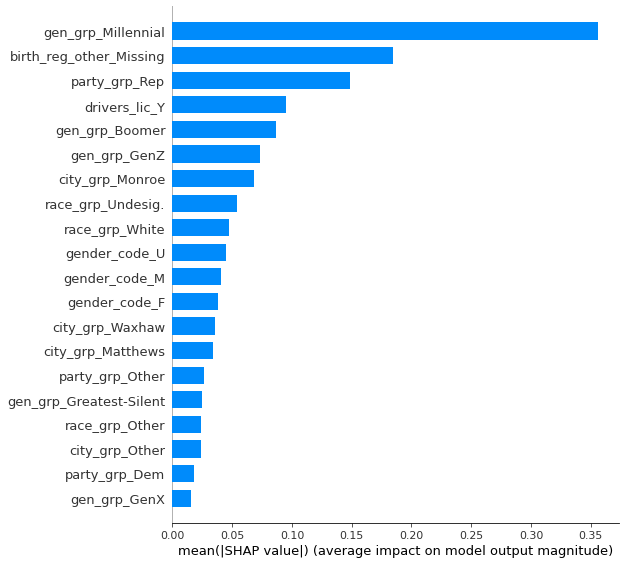

In [41]:
## Display mean abs(SHAP value) for each feature for the full training set
shap.summary_plot(bin_2016_shap_values, X_2016_train_df, plot_type='bar')

The plot below is similar to that above in that it ranks the top features based on mean SHAP values (so the ordering is the same). Each point represents a voter in the training set. The grey vertical line at 0.0 represents SHAP values that had 0 impact on model output, so the farther the points are from the grey line, the more important the feature was in terms of predicting that voter's participation in the election (whether they voted or not). Negative SHAP values to the left of the grey line push the model towards a prediction of 0 or "No Vote" whereas positive SHAP values push the model towards a prediction of 1 or "Vote". 

Since all the features were label encoded, each feature is a binary variable representing whether the voter does or does not belong to the category listed at the end of the feature name (so 1 for `gen_grp_Millenial` means the person is a millennial). Thus high values of 1 are color coded red and low values of 0 are color coded blue.

**Top 3 Features Explained**:

1. `gen_grp_Millennial` - Being a millenial (1, red) pushed the model towards a prediction of "No Vote".


2. `birth_reg_other_Missing` - Voters whose record was missing their birthplace information (1, red) were more likely to vote.


3. `party_grp_Rep` - Being a Republican (1, red) pushed the model towards a prediction of "Vote" and not being a Republican (0, blue) pushed the model towards a prediction of "No Vote".

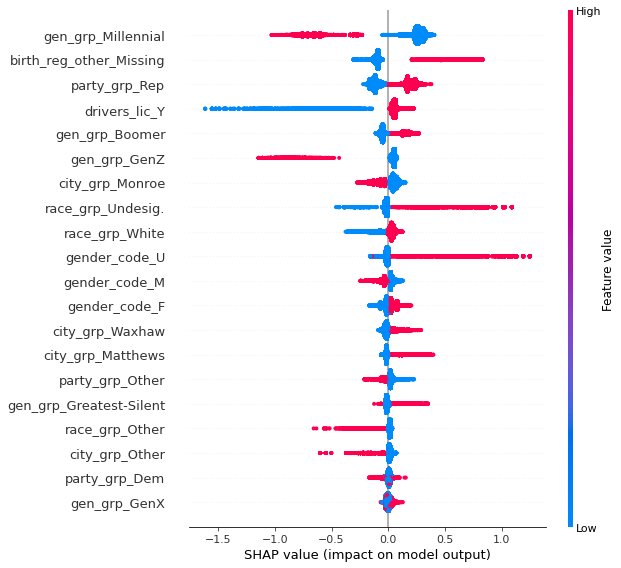

In [42]:
## Display mean abs(SHAP value) for each feature for the full training set
shap.summary_plot(bin_2016_shap_values, X_2016_train_df)

### 2016 Multiclass Target Model

In [43]:
## Store the booster (trained model)
multi_2016_model = xgb_multi_2016_smote_bacc_grid.best_estimator_.named_steps['xgb'].get_booster()

## Explain the model's predictions using SHAP
multi_2016_explainer = shap.TreeExplainer(multi_2016_model)
multi_2016_shap_values = multi_2016_explainer.shap_values(X_2016_train_df)

## multi_2016_shap_values is a list of 3 arrays, one for each class
print(type(multi_2016_shap_values))
print(type(multi_2016_shap_values[0]))
print(multi_2016_shap_values[0].shape)
len(multi_2016_shap_values)

## Check order of label encoded classes
le_2016.classes_

## Store each class' array of values separately
early_multi_2016_shap = multi_2016_shap_values[0].shape
elec_multi_2016_shap = multi_2016_shap_values[1].shape
no_multi_2016_shap = multi_2016_shap_values[2].shape

## Print model pred and ground truth label for third row of training set
  ## and visualize prediction explanation
multi_shap_force(xgb_multi_2016_smote_bacc_grid.best_estimator_, 'xgb', 2,
                     X_2016_train_df, y_multi_2016_train,
                     multi_2016_explainer, multi_2016_shap_values)

<class 'list'>
<class 'numpy.ndarray'>
(91545, 27)


Model Prediction: 2 - No Vote
Ground Truth Label: 2 - No Vote

Early Vote Class (0)



Election Day Vote Class (1)



No Vote Class (2)


The plots above visualize how the model is making its prediction for the third individual in the training set. 
> The third individual did not vote and the model predicted this correctly. The breakdown for the "No Vote" class is shown in the third plot. The other two plots show how the features influenced the model's prediction for this person for the other two classes, but in the case of multiclass models, the class with the highest score was ultimately the predicted output for each voter.

> Examining the bottom plot, the model was pushed towards the prediction of "No Vote" by the fact that the individual belongs to Gen Z (and thus is not a Baby Boomer). The fact that the individual is not a Republican, is not missing birthplace information, and resides in Monroe also pushed the model towards the correct prediction for this individual.

In [44]:
## Print model pred and ground truth label for seventh row of training set
  ## and visualize prediction explanation
multi_shap_force(xgb_multi_2016_smote_bacc_grid.best_estimator_, 'xgb', 6,
                     X_2016_train_df, y_multi_2016_train,
                     multi_2016_explainer, multi_2016_shap_values)

Model Prediction: 0 - Early
Ground Truth Label: 0 - Early

Early Vote Class (0)



Election Day Vote Class (1)



No Vote Class (2)


The plots above visualize how the model is making its prediction for the seventh individual in the training set. 
> The seventh individual voted early, and the model predicted this correctly. The breakdown for the "Early" class is shown in the first plot. For multiclass models, the class with the highest score was ultimately the predicted output for each voter.

> Examining the top plot, the model was pushed towards the prediction of "Early" by the fact that the individual is a Baby Boomer (and thus not a millennial), that their birthplace information is missing in their registration record, and they are not a male. The fact that the individual resides in Monroe and is not a Republican pushed the model in the opposite direction, but not enough to overwhelm the factors more predictive of "Early".

The plot below shows the impact each feature had on the model's output (predictions) quantified in terms of SHAP values. The top 5 features (after which there is a drop in impact) are `gen_grp_Millennial`, `birth_reg_other_Missing`, `gen_grp_Boomer`, `gen_grp_GenX`, and `party_grp_Rep`. These are very similar to the top features for the binary target model, and are in a very similar order. Obviously age group is important because it makes up 3 of the top 5 features. Whether or not a person's voter registration record lists their birthplace is the second most impactful feature on model output, and whether or not the voter registered as a Republican is the fifth most impactful feature. The colors of the bars represent how much the particular feature influenced the prediction for each class, but these trends are more easily visualized in the non-bar summary plots that follow.

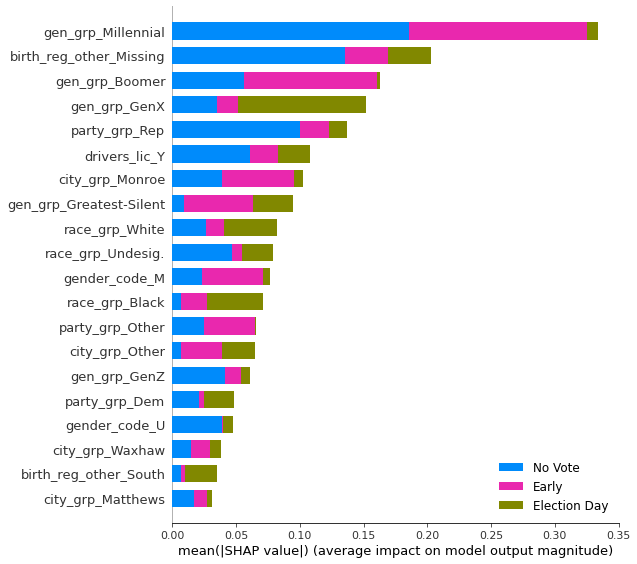

In [45]:
## Display mean abs(SHAP value) of each feature for the full training set
  ## for all classes
shap.summary_plot(multi_2016_shap_values, X_2016_train_df,
                  plot_type='bar', class_names=le_2016.classes_)

The plots that follow are similar to the above plot in that they rank the top features based on mean SHAP values, but each plot ranks the features for one of the 3 target classes ("Early", "Election Day", and then "No Vote" respectively). Each point represents a voter in the training set. The grey vertical line at 0.0 represents SHAP values that had 0 impact on model output, so the farther the points are from the grey line, the more important the feature was in terms of predicting that voter's participation in the election. Negative SHAP values to the left of the grey line push the model towards a prediction of 0 for the particular class (in other words, not the class in question), whereas positive SHAP values push the model towards a prediction of the class in question (1). 

Since all the features were label encoded, each feature is a binary variable representing whether the voter does or does not belong to the category listed at the end of the feature name (so 1 for `gen_grp_Millenial` means the person is a millennial). Thus high values of 1 are color coded red and low values of 0 are color coded blue.

---

**Top 5 Features for the "Early" Class Explained**:

1. `gen_grp_Millennial` - Being a millenial (1, red) pushed the model away from a prediction of "Early".


2. `gen_grp_Boomer` - Belonging to the Baby Boomer generation (1, red) pushed the model towards a prediction of "Early".


3. `city_grp_Monroe` - Residing in Monroe (1, red) pushed the model away from a prediction of "Early".


4. `gen_grp_Greatest-Silent` - Belonging to the Greatest/ Silent generation age group (1, red) pushed the model towards a prediction of "Early".

5. `gender_code_M` - Being male (1, red) pushed the model away from a prediction of "Early", while not being male (0, blue) pushed the model towards a prediction of "Early".



******************** Early Class ********************


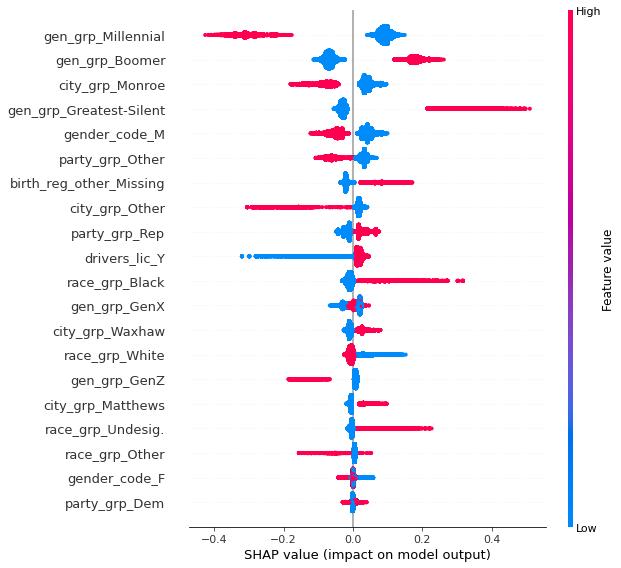

In [46]:
multi_shap_summ(multi_2016_shap_values, X_2016_train_df, 0);

---

**Top 5 Features for the "Election Day" Class Explained**:

1. `gen_grp_GenX` - Belonging to Generation X (1, red) pushed the model towards a prediction of "Election Day" while not belonging to Generation X (0, blue) pushed the model away from a prediction of "Election Day".


2. `race_grp_Black` - Being Black (1, red) pushed the model away from a prediction of "Election Day".


3. `race_grp_White` - Not being wlack (0, blue) pushed the model away from a prediction of "Election Day".


4. `birth_reg_other_Missing` - Missing birthplace information (1, red) pushed the model towards a prediction of "Election Day".


5. `gen_grp_Greatest-Silent` - Belonging to the Greatest-Silent generation age group pushed the model away from a prediction of "Election Day".



******************** Election Day Class ********************


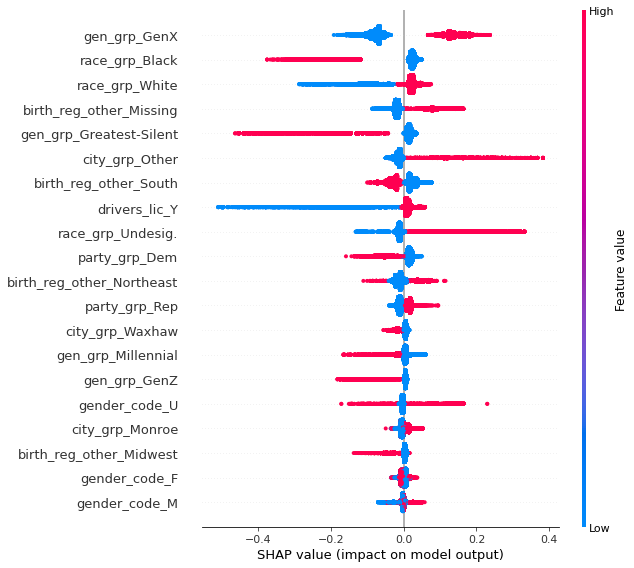

In [47]:
multi_shap_summ(multi_2016_shap_values, X_2016_train_df, 1);

---

**Top 5 Features for the "No Vote" Class Explained**:

1. `gen_grp_Millennial` - Being a millenial (1, red) pushed the model towards a prediction of "No Vote".


2. `birth_reg_other_Missing` - Missing information about birthplace (1, red) pushed the model away from a prediction of "No Vote".


3. `party_grp_Rep` - Being a Republican (1, red) pushed the model away from a prediction of "No Vote" and not being a Republican (0, blue) pushed the model towards a prediction of "No Vote".


4. `drivers_lic_Y` - Not having a drivers license (0, blue) pushed the model towards a prediction of "No Vote".


5. `gen_grp_Boomer` - Being a Baby Boomer (1, red) pushed the model away from a prediction of "No Vote".



******************** No Vote Class ********************


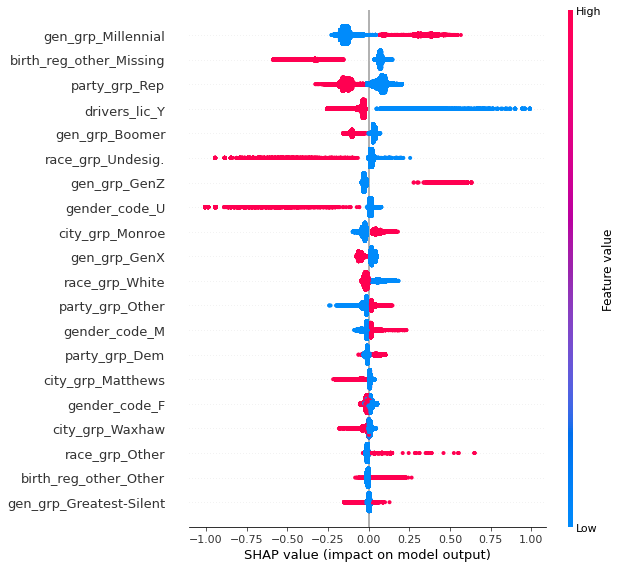

In [48]:
multi_shap_summ(multi_2016_shap_values, X_2016_train_df, 2);